<a href="https://colab.research.google.com/github/dkisselev-zz/llm_engineering/blob/wk7/Week_7_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Predict Product Prices

### And now, to evaluate our fine-tuned open source model



In [ ]:
# pip installs

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 908.2/908.2 MB 205.6 MB/s eta 0:00:01
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 98.0 MB/s eta 0:00:00


In [1]:
# imports

import os
import re
import math
import numpy as np
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import wandb
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [2]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
# HF_USER = "dkisselev" # your HF name here! Or use mine if you just want to reproduce my results.
HF_USER = "dkisselev"

# The run itself

# RUN_NAME = "2025-10-23_23.41.24"
RUN_NAME = "2024-09-13_13.04.39"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
# REVISION = None
REVISION = "e8d637df551603dc86cd7a1598a8f44af4d7ae36" # or REVISION = None
# FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Uncomment this line if you wish to use my model
FINETUNED_MODEL = f"ed-donner/{PROJECT_RUN_NAME}"

WANDB_ENTITY = "dkisselev"
os.environ["WANDB_API_KEY"]=userdata.get('WANDB_API_KEY')
MODEL_ARTIFACT_NAME = "model-2025-10-23_23.41.24"
REVISION_TAG="v22"
WANDB_ARTIFACT_PATH = f"{WANDB_ENTITY}/{PROJECT_NAME}/{MODEL_ARTIFACT_NAME}:{REVISION_TAG}"

# Data

# DATASET_NAME = f"{HF_USER}/pricer-data2"
# Or just use the one I've uploaded
DATASET_NAME = "ed-donner/pricer-data"

# Hyperparameters for QLoRA

QUANT_4_BIT = False

%matplotlib inline

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

### Log in to HuggingFace

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.


In [3]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token)

In [4]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [7]:
train[0]


{'text': 'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00',
 'price': 226.95}

## Now load the Tokenizer and Model

In [5]:
# pick the right quantization (thank you Robert M. for spotting the bug with the 8 bit version!)

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

Unused kwargs: ['bnb_8bit_compute_dtype']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [6]:
# Load model from w&b
artifact = wandb.Api().artifact(WANDB_ARTIFACT_PATH, type='model')
artifact_dir = artifact.download() # Downloads to a local cache dir

wandb: Downloading large artifact 'model-2025-10-23_23.41.24:v22', 328.81MB. 11 files...
wandb:   11 of 11 files downloaded.  
Done. 00:00:00.2 (1319.5MB/s)


In [7]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
# if REVISION:
#   fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
# else:
#   fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

# Model at W&B
fine_tuned_model = PeftModel.from_pretrained(base_model, artifact_dir)

print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 9190.3 MB


# THE MOMENT OF TRUTH!

## Use the model in inference mode

Remember, GPT-4o had an average error of \$76.  
Llama 3.1 base model had an average error of \$396.   
This human had an error of \$127.  

## Caveat

Keep in mind that prices of goods vary considerably; the model can't predict things like sale prices that it doesn't have any information about.

In [8]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [9]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(
        inputs,
        attention_mask=attention_mask,
        max_new_tokens=3,
        num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [10]:
def calculate_weighted_price(prices, probabilities):
    """
    Calculates a normalized weighted average price.

    Args:
        prices (list or np.array): A list of prices.
        probabilities (list or np.array): A list of corresponding probabilities (or weights).
                                        These do not need to sum to 1.

    Returns:
        float: The normalized weighted average price.
    """
    # Convert lists to numpy arrays for efficient calculation
    prices_array = np.array(prices)
    probs_array = np.array(probabilities)

    # Calculate the total of the probabilities to use for normalization
    total_prob = np.sum(probs_array)

    # Avoid division by zero. If all probs are 0, return a simple average.
    if total_prob == 0:
        return np.mean(prices_array)

    # Normalize the probabilities to get the weights
    weights = probs_array / total_prob

    # Calculate the weighted average by multiplying prices by their weights and summing up
    weighted_price = np.sum(prices_array * weights)

    return weighted_price

In [51]:
top_K = 20

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)

    prices = []
    # Renamed 'weights' to 'probabilities' for clarity
    probabilities = []

    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      # This is a torch.Tensor
      probability_tensor = top_prob[0][i]

      print(predicted_token, probability_tensor)

      try:
        # Try to convert the decoded token string to a float
        price = float(predicted_token)
      except ValueError as e:
        price = 0.0

      # Only include valid, positive prices
      if price > 0:
        prices.append(price)
        # We append the tensor to our list
        probabilities.append(probability_tensor)

    if not prices:
      # If no valid prices were found, return 0.0
      return 0.0

    # --- MODIFIED SECTION ---
    # Use the numpy weighted average technique

    # 1. Convert the list of prices to a numpy array
    prices_np = np.array(prices)

    # 2. Convert the list of torch.Tensors to a numpy array of floats
    probs_np = np.array([p.item() for p in probabilities])

    # 3. Calculate the normalized weighted average
    # This is equivalent to: sum(prices_np * probs_np) / sum(probs_np)
    final_price = np.average(prices_np, weights=probs_np)

    return float(final_price) # Return as a standard python float

In [26]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

# top_K = 3

# def improved_model_predict(prompt, device="cuda"):
#     set_seed(42)
#     inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
#     attention_mask = torch.ones(inputs.shape, device=device)

#     with torch.no_grad():
#         outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
#         next_token_logits = outputs.logits[:, -1, :].to('cpu')

#     next_token_probs = F.softmax(next_token_logits, dim=-1)
#     top_prob, top_token_id = next_token_probs.topk(top_K)
#     prices, weights = [], []
#     for i in range(top_K):
#       predicted_token = tokenizer.decode(top_token_id[0][i])
#       print(predicted_token, top_prob[0][i])
#       probability = top_prob[0][i]
#       try:
#         result = float(predicted_token)
#       except ValueError as e:
#         result = 0.0
#       if result > 0:
#         prices.append(result)
#         weights.append(probability)
#     if not prices:
#       return 0.0, 0.0
#     total = sum(weights)
#     weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
#     return sum(weighted_prices).item()

In [25]:
# # An improved prediction function takes the median of the top 3 choices
# # This code would be more complex if we couldn't take advantage of the fact
# # That Llama generates 1 token for any 3 digit number

# top_K = 3

# def improved_model_predict(prompt, device="cuda"):
#     set_seed(42)
#     inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
#     attention_mask = torch.ones(inputs.shape, device=device)

#     with torch.no_grad():
#         outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
#         next_token_logits = outputs.logits[:, -1, :].to('cpu')

#     next_token_probs = F.softmax(next_token_logits, dim=-1)
#     top_prob, top_token_id = next_token_probs.topk(top_K)
#     prices = []
#     for i in range(top_K):

#       predicted_token = tokenizer.decode(top_token_id[0][i])
#       # print(predicted_token, top_prob[0][i])

#       probability = top_prob[0][i]
#       try:
#         result = float(predicted_token)
#       except ValueError as e:
#         result = 0.0
#       if result > 0:
#         prices.append(result)

#     if not prices:
#       return 0.0

#     # Calculate the median
#     prices.sort()
#     mid = len(prices) // 2
#     median_price = (prices[mid] + prices[~mid]) / 2 if len(prices) % 2 == 0 else prices[mid]

#     return median_price

In [12]:
test[80]

{'text': "How much does this cost to the nearest dollar?\n\nLongacre Aluminum Turn Plates\nLongacre is an established brand name in the racing industry and is recognized for dedication to quality, innovation and customer satisfaction. Check out our comprehensive line of race scales, alignment tools, racing gauges and other products. Whether you are into stock, modified, drag, go kart, off-road, sprint or RC car racing, we'll provide you with the quality racing parts you deserve. The free floating in 2 directions eliminates bind It reads to 1/2° - Degrees can be zeroed with the car on The low profile design means that its only 1 tall Can also be used on top of scale pads Has a weight capacity of 1,500 lbs. per scale Manufacturer Longacre, Brand Longacre, Model Longacre Racing Products, Weight 31\n\nPrice is $",
 'price': 940.33}

In [12]:
def make_prompt(text):
  p_array = text.split("\n")
  p_question = p_array[0].replace("How much does this cost to the nearest dollar?","What is the price of this item?")
  p_title = p_array[2]
  p_descr = re.sub(r'\d', '', p_array[3])
  p_price = p_array[5]
  prompt =  p_title + "\n" + p_descr + "\n" + "Question: "+ p_question + "\n\n" + p_price
  # prompt = p_array[0] + "\n\n\n" + p_title + "\n\n" + p_descr + "\n\n" + p_price
  # return text
  return prompt

In [14]:
prompt=make_prompt(test[80]['text'])
print(prompt)

improved_model_predict(prompt)

Longacre Aluminum Turn Plates
Longacre is an established brand name in the racing industry and is recognized for dedication to quality, innovation and customer satisfaction. Check out our comprehensive line of race scales, alignment tools, racing gauges and other products. Whether you are into stock, modified, drag, go kart, off-road, sprint or RC car racing, we'll provide you with the quality racing parts you deserve. The free floating in  directions eliminates bind It reads to /° - Degrees can be zeroed with the car on The low profile design means that its only  tall Can also be used on top of scale pads Has a weight capacity of , lbs. per scale Manufacturer Longacre, Brand Longacre, Model Longacre Racing Products, Weight 
Question: What is the price of this item?

Price is $


138.63358778625954

In [13]:
FEW_SHOT_EXAMPLES = """
BATHLAVISH Utility Sink Faucet Wall Mount Commercial Kitchen 12 Inch Length Swivel Spout 2 Handle Bar Laundry Polished Chrome Mixer Tap\nHeavy Duty Brass Constructed wall mount kitchen faucet, 12” swivel spout, Chrome polished, engineered design and built for performance & dependability. Sturdy heavy duty brass construction for extra durability and longevity. Reinforced double O-Ring valves to avoid leakage, with hot and cold mark on stem. Color coded red and blue handles with heavy duty double O-ring swivel spout. Wall Mount Installation, 1/2 NPT female inlets, ideal for use in kitchen, commercial, laundry, restaurant, farm etc. Brand BATHLAVISH, Mounting Type Wall Mount, Finish Type Chrome, Material Brass,

Price is $65.99

Coverking Custom Fit Front 50/50 Bucket Seat Cover for Select Chevrolet Silverado HD Models - Neosupreme (Charcoal with Black Sides)\nThe exact seat configuration is Front 50/50 Bucket; Without Armrest; Without Built-In Shoulder Belt Made from Neosupreme fabric for insulation, soft touch, and comfort Neosupreme seat covers are water-resistant and are an affordable alternative to Neoprene Tailor-made to the exact specifications of your vehicles seats and protects your seats from spills, stains, and damage Stitching designed to emulate factory seat style and the high quality buckles and zippers enable for a secure fit Designed to install yourself (installation may require some effort for a snug fit) and includes a 1 year limited warranty against defects Manufacturer Coverking, Brand

Price is $202.81
"""

class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]

        base_prompt = datapoint["text"]
        prompt = make_prompt(base_prompt)

        guess = self.predictor(prompt)

        # guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

Streaming output truncated to the last 5000 lines.
240 tensor(0.0204, dtype=torch.float16)
250 tensor(0.0186, dtype=torch.float16)
300 tensor(0.0175, dtype=torch.float16)
270 tensor(0.0150, dtype=torch.float16)
280 tensor(0.0128, dtype=torch.float16)
260 tensor(0.0124, dtype=torch.float16)
210 tensor(0.0106, dtype=torch.float16)
299 tensor(0.0103, dtype=torch.float16)
290 tensor(0.0103, dtype=torch.float16)
220 tensor(0.0100, dtype=torch.float16)
350 tensor(0.0097, dtype=torch.float16)
230 tensor(0.0094, dtype=torch.float16)
400 tensor(0.0094, dtype=torch.float16)
249 tensor(0.0091, dtype=torch.float16)
190 tensor(0.0088, dtype=torch.float16)
199 tensor(0.0085, dtype=torch.float16)
330 tensor(0.0083, dtype=torch.float16)
180 tensor(0.0083, dtype=torch.float16)
320 tensor(0.0080, dtype=torch.float16)
200 tensor(0.0078, dtype=torch.float16)
13: Guess: $263.94 Truth: $205.50 Error: $58.44 SLE: 0.06 Item: Solar HAMMERED BRONZ...
300 tensor(0.0634, dtype=torch.float16)
250 tensor(0.0509, dt

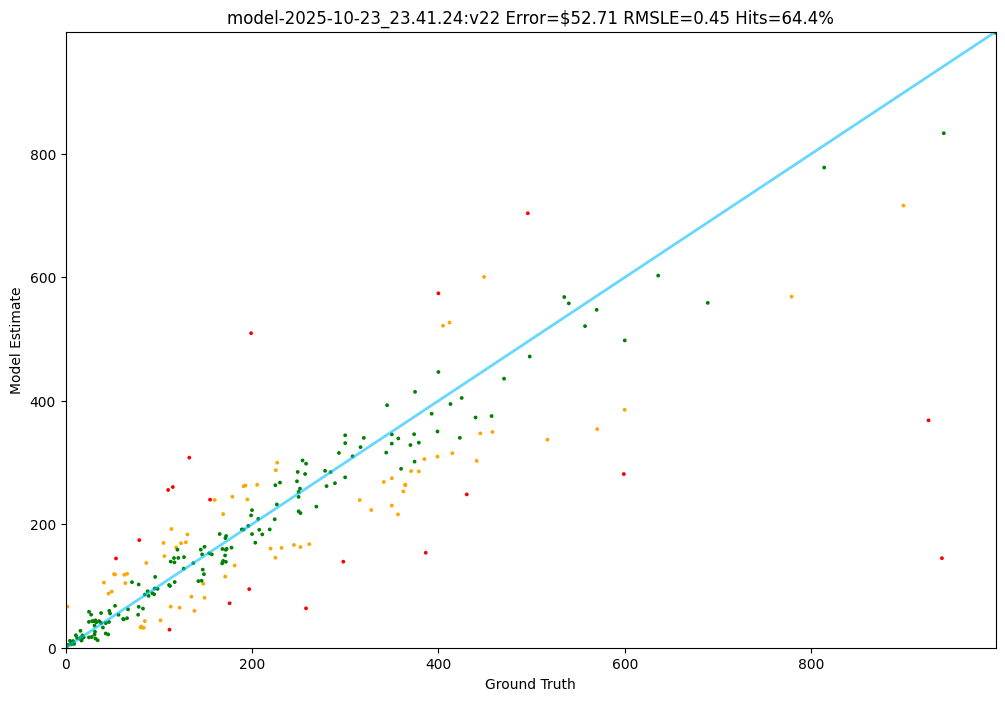

In [52]:
tester = Tester(improved_model_predict, test, title=f"{MODEL_ARTIFACT_NAME}:{REVISION_TAG}")
tester.run()

In [97]:
test[80]

{'text': "How much does this cost to the nearest dollar?\n\nLongacre Aluminum Turn Plates\nLongacre is an established brand name in the racing industry and is recognized for dedication to quality, innovation and customer satisfaction. Check out our comprehensive line of race scales, alignment tools, racing gauges and other products. Whether you are into stock, modified, drag, go kart, off-road, sprint or RC car racing, we'll provide you with the quality racing parts you deserve. The free floating in 2 directions eliminates bind It reads to 1/2° - Degrees can be zeroed with the car on The low profile design means that its only 1 tall Can also be used on top of scale pads Has a weight capacity of 1,500 lbs. per scale Manufacturer Longacre, Brand Longacre, Model Longacre Racing Products, Weight 31\n\nPrice is $",
 'price': 940.33}

1: Truth: $374.41. Errors (k=1, k=20, k=5000): ($81.41, $72.98, $51.95) Item: OEM AC Compressor w/...
2: Truth: $225.11. Errors (k=1, k=20, k=5000): ($84.11, $79.28, $59.00) Item: Motorcraft YB3125 Fa...


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:573: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


3: Truth: $61.68. Errors (k=1, k=20, k=5000): ($20.68, $15.16, $nan) Item: Dorman Front Washer ...
4: Truth: $599.99. Errors (k=1, k=20, k=5000): ($99.99, $102.15, $79.59) Item: HP Premium HD Plus T...
5: Truth: $16.99. Errors (k=1, k=20, k=5000): ($7.99, $5.32, $0.34) Item: Super Switch Pickup ...
6: Truth: $31.99. Errors (k=1, k=20, k=5000): ($19.99, $17.14, $11.46) Item: Horror Bookmarks, Re...
7: Truth: $101.79. Errors (k=1, k=20, k=5000): ($60.79, $57.23, $nan) Item: SK6241 - Stinger 4 G...
8: Truth: $289.00. Errors (k=1, k=20, k=5000): ($10.00, $22.44, $7.98) Item: Godox ML60Bi LED Lig...
9: Truth: $635.86. Errors (k=1, k=20, k=5000): ($135.86, $32.93, $37.37) Item: Randall G3 Plus Comb...
10: Truth: $65.99. Errors (k=1, k=20, k=5000): ($44.01, $53.50, $nan) Item: HOLDWILL 6 Pack LED ...
11: Truth: $254.21. Errors (k=1, k=20, k=5000): ($45.79, $49.20, $62.56) Item: Viking Horns 3 Gallo...
12: Truth: $412.99. Errors (k=1, k=20, k=5000): ($12.99, $18.22, $19.90) Item: CURT 70110 Cu

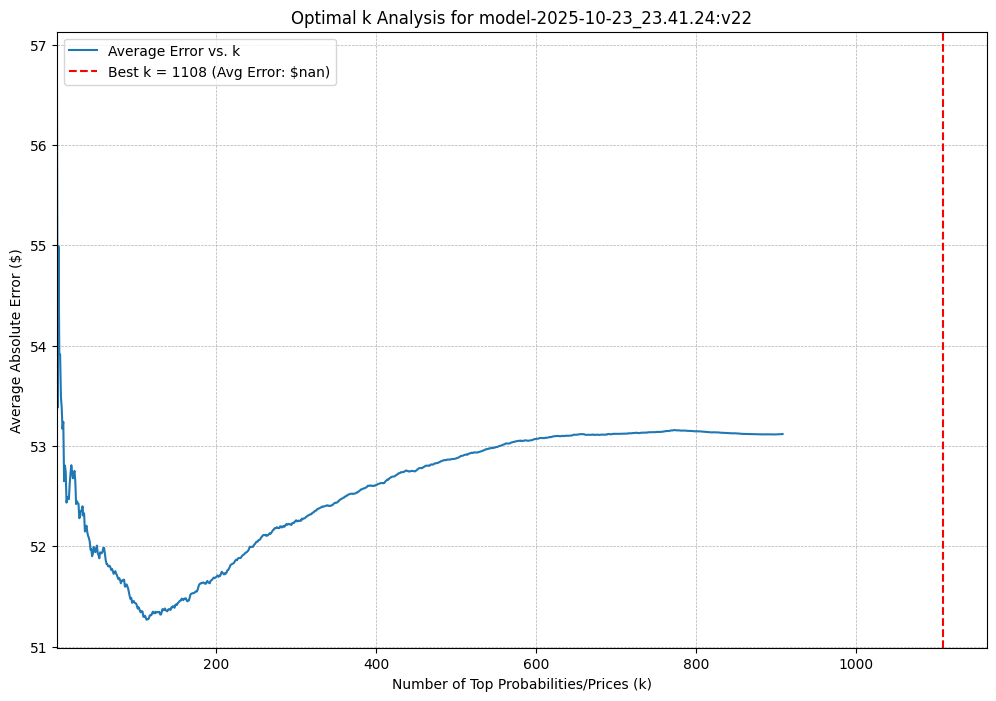

In [58]:
# --- (Your helper functions and model variables) ---
# Ensure the following are defined in your script:
# set_seed, tokenizer, fine_tuned_model, make_prompt, test (data)
# MODEL_ARTIFACT_NAME, REVISION_TAG, COLOR_MAP, RESET
# ---------------------------------------------------

def calculate_weighted_price(prices, probabilities):
    """
    Calculates a normalized weighted average price.
    (This function is unchanged)

    Args:
        prices (list or np.array): A list of prices.
        probabilities (list or np.array): A list of corresponding probabilities (or weights).

    Returns:
        float: The normalized weighted average price.
    """
    prices_array = np.array(prices)
    probs_array = np.array(probabilities)

    total_prob = np.sum(probs_array)

    if total_prob == 0:
        # Handle case with no/zero probabilities
        if len(prices_array) > 0:
            return np.mean(prices_array)
        else:
            return 0.0 # No prices and no probabilities

    # Use np.average for a robust and clean weighted average
    weighted_price = np.average(prices_array, weights=probs_array)

    return weighted_price

# Set the maximum number of probabilities to fetch
TOP_K = 900

def get_top_k_predictions(prompt, device="cuda"):
    """
    MODIFIED: Gets the top K price/probability pairs from the model.

    Returns:
        (list, list): A tuple containing (prices, probabilities)
    """
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(TOP_K)

    prices = []
    probabilities = []

    for i in range(TOP_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability_tensor = top_prob[0][i]

      try:
        price = float(predicted_token)
      except ValueError as e:
        price = 0.0

      # Only include valid, positive prices
      if price > 0:
        prices.append(price)
        # Store the probability as a simple float
        probabilities.append(probability_tensor.item())

    if not prices:
      return [], []

    # Return the raw lists for analysis
    return prices, probabilities


class Tester:
    """
    MODIFIED: This class now tests for the optimal 'k' value.
    """
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor # This will be get_top_k_predictions
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.truths = []

        # This will store the errors for each k for every inference
        # Shape: (self.size, TOP_K)
        # self.all_k_errors[i][k-1] = error for inference i at k
        self.all_k_errors = []
        self.max_k = TOP_K

    def run_datapoint(self, i):
        datapoint = self.data[i]
        base_prompt = datapoint["text"]
        prompt = make_prompt(base_prompt)
        truth = datapoint["price"]
        self.truths.append(truth)

        # 1. Get the raw lists of prices and probabilities
        prices, probabilities = self.predictor(prompt)

        errors_for_this_datapoint = []

        if not prices:
            # Handle cases where the model returned no valid prices
            print(f"{i+1}: No valid prices found. Truth: ${truth:,.2f}.")
            # Assign the error (abs(0 - truth)) for all k values
            error = np.abs(0 - truth)
            errors_for_this_datapoint = [error] * self.max_k
            self.all_k_errors.append(errors_for_this_datapoint)
            return

        # 2. Iterate from k=1 up to max_k
        for k in range(1, self.max_k + 1):
            # Get the top k prices/probs
            # Python slicing handles k > len(prices) gracefully
            k_prices = prices[:k]
            k_probabilities = probabilities[:k]

            # 3. Calculate the weighted price just for this k
            guess = calculate_weighted_price(k_prices, k_probabilities)

            # 4. Calculate and store the error for this k
            error = np.abs(guess - truth)
            errors_for_this_datapoint.append(error)

        # Store the list of errors (for k=1 to max_k) for this inference
        self.all_k_errors.append(errors_for_this_datapoint)

        # Print a summary for this datapoint
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        # Using [0], [19], [-1] for k=1, k=20, k=max_k (0-indexed)
        k_1_err = errors_for_this_datapoint[0]
        k_20_err = errors_for_this_datapoint[19]
        k_max_err = errors_for_this_datapoint[-1]

        # --- FIX IS ON THIS LINE ---
        # Assuming COLOR_MAP is a dict and RESET is a string
        print(f"{COLOR_MAP.get('orange', '')}{i+1}: Truth: ${truth:,.2f}. "
              f"Errors (k=1, k=20, k={self.max_k}): "
              f"(${k_1_err:,.2f}, ${k_20_err:,.2f}, ${k_max_err:,.2f}) "
              f"Item: {title}{RESET}") # Removed .get('', '') from RESET

    def plot_k_vs_error(self, k_values, avg_errors_by_k, best_k, min_error):
        """
        NEW: Plots the Average Error vs. k
        """
        plt.figure(figsize=(12, 8))
        plt.plot(k_values, avg_errors_by_k, label='Average Error vs. k')

        # Highlight the best k
        plt.axvline(x=best_k, color='red', linestyle='--',
                    label=f'Best k = {best_k} (Avg Error: ${min_error:,.2f})')

        plt.xlabel('Number of Top Probabilities/Prices (k)')
        plt.ylabel('Average Absolute Error ($)')
        plt.title(f'Optimal k Analysis for {self.title}')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # Set x-axis to start at 1
        plt.xlim(left=1)
        plt.show()

    def report(self):
        """
        MODIFIED: Performs the final analysis and plots the k-vs-error graph.
        """
        # 1. Convert list of lists to a 2D numpy array (inferences x k_values)
        errors_array = np.array(self.all_k_errors)

        # 2. Calculate the average error for each k (column-wise mean)
        # axis=0 means calculate mean *down* the columns
        avg_errors_by_k = np.mean(errors_array, axis=0)

        # 3. Find the best k (index of the minimum average error)
        best_k_index = np.argmin(avg_errors_by_k)
        min_error = avg_errors_by_k[best_k_index]

        # k is 1-based, but our index is 0-based
        best_k = best_k_index + 1

        print("\n--- Optimal k Analysis Report ---")
        print(f"Model: {self.title}")
        print(f"Inferences Run: {self.size}")
        print(f"Analyzed k from 1 to {self.max_k}")
        print(f"===================================")
        print(f"==> Best k: {best_k}")
        print(f"==> Minimum Average Error: ${min_error:,.2f}")
        print(f"===================================")

        # 4. Plot the graph
        k_values = np.arange(1, self.max_k + 1)
        self.plot_k_vs_error(k_values, avg_errors_by_k, best_k, min_error)

    def run(self):
        for i in range(self.size):
            self.run_datapoint(i)
        # The report now does all the analysis and plotting
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

# --- MODIFIED EXECUTION ---
# Pass the new function 'get_top_k_predictions' to the Tester
tester = Tester(get_top_k_predictions, test, title=f"{MODEL_ARTIFACT_NAME}:{REVISION_TAG}")
tester.run()

1: Truth: $374.41. Errors (k=1, k=20, k=100): ($81.41, $73.24, $67.97) Item: OEM AC Compressor w/...
2: Truth: $225.11. Errors (k=1, k=20, k=100): ($84.11, $80.03, $82.84) Item: Motorcraft YB3125 Fa...
3: Truth: $61.68. Errors (k=1, k=20, k=100): ($20.68, $15.16, $3.86) Item: Dorman Front Washer ...
4: Truth: $599.99. Errors (k=1, k=20, k=100): ($99.99, $102.15, $89.32) Item: HP Premium HD Plus T...
5: Truth: $16.99. Errors (k=1, k=20, k=100): ($7.99, $5.32, $1.49) Item: Super Switch Pickup ...
6: Truth: $31.99. Errors (k=1, k=20, k=100): ($19.99, $17.74, $13.03) Item: Horror Bookmarks, Re...
7: Truth: $101.79. Errors (k=1, k=20, k=100): ($60.79, $57.40, $45.58) Item: SK6241 - Stinger 4 G...
8: Truth: $289.00. Errors (k=1, k=20, k=100): ($10.00, $22.44, $12.82) Item: Godox ML60Bi LED Lig...
9: Truth: $635.86. Errors (k=1, k=20, k=100): ($135.86, $32.93, $33.48) Item: Randall G3 Plus Comb...
10: Truth: $65.99. Errors (k=1, k=20, k=100): ($44.01, $53.82, $52.82) Item: HOLDWILL 6 Pack LED

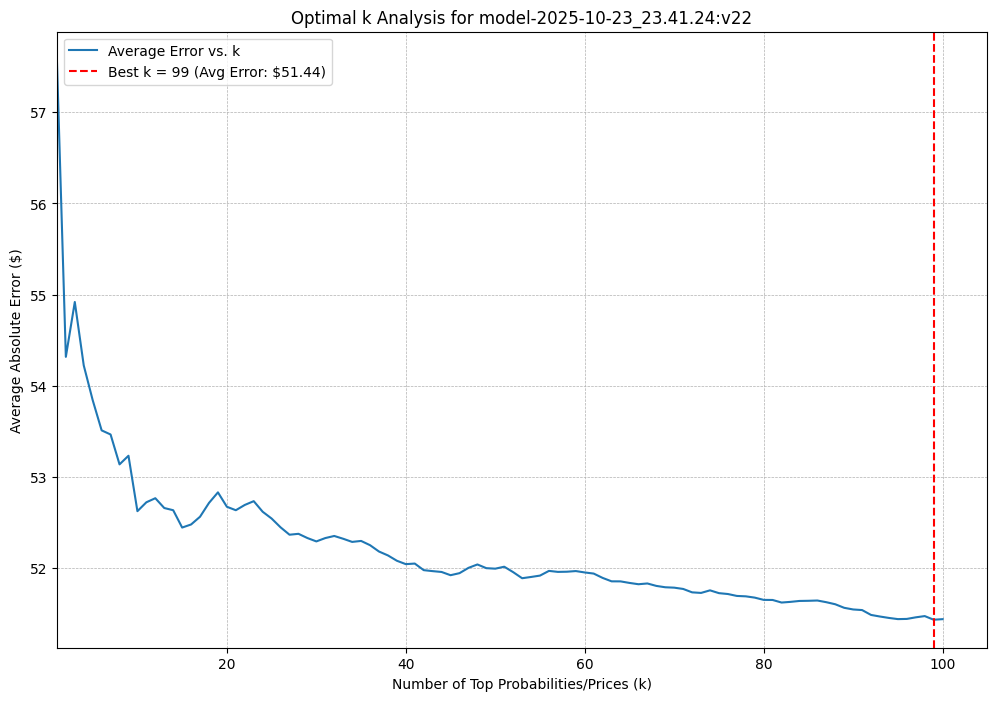


--- Probability Spread Analysis ---
Lowest spread (std):  0.000323 (Inference 48)
Median spread (std): 0.004324 (Inference 59)
Highest spread (std): 0.102938 (Inference 91)


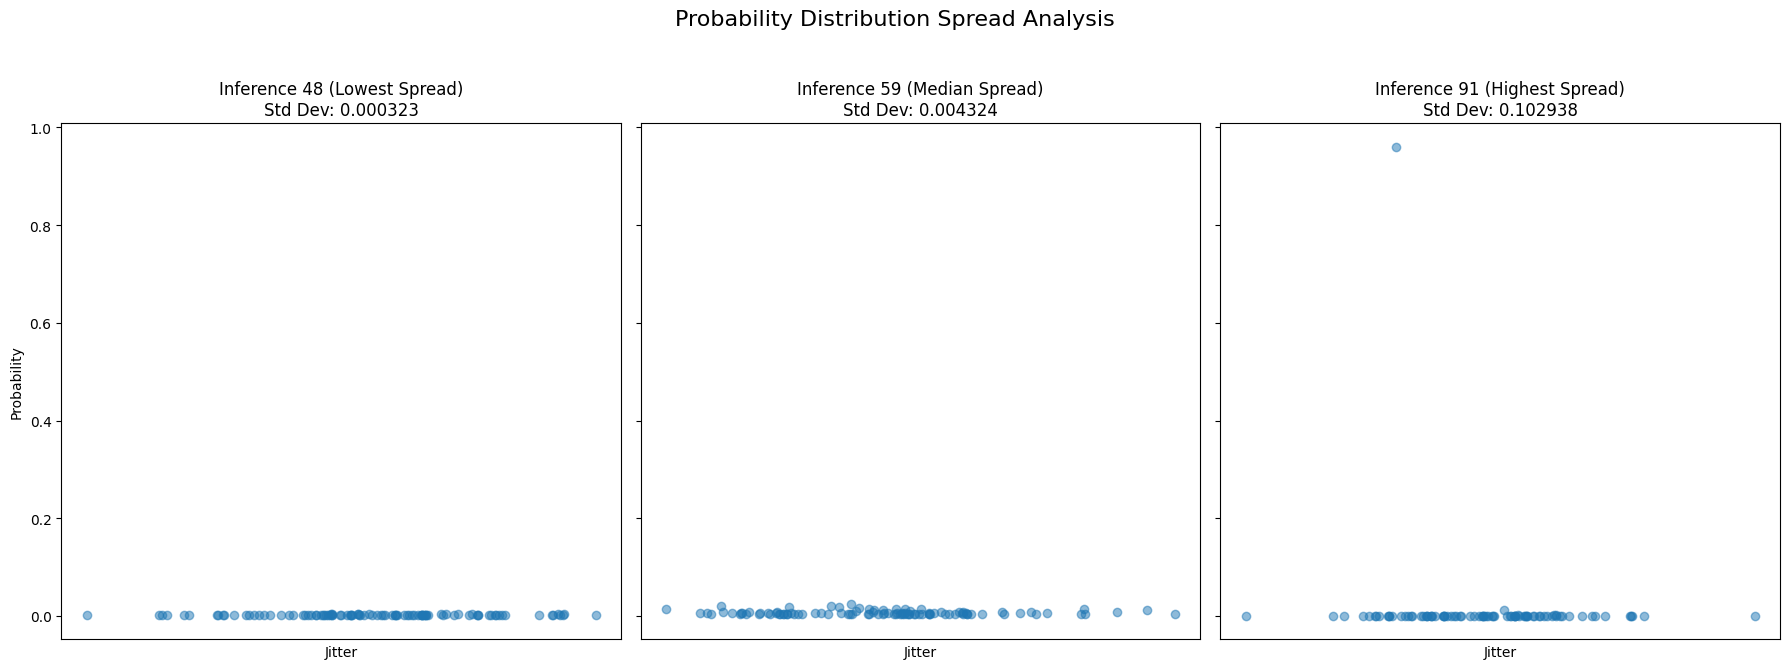

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn.functional as F

# ... (All your other functions like calculate_weighted_price,
#      get_top_k_predictions, set_seed, etc. remain the same) ...

class Tester:
    """
    MODIFIED: This class now also analyzes and plots probability spread.
    """
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.truths = []

        # From previous step
        self.all_k_errors = []
        self.max_k = TOP_K

        # --- NEW FOR SPREAD ANALYSIS ---
        # Store the list of probabilities for each inference
        self.all_prob_lists = []
        # Store the standard deviation of probs for each inference
        self.prob_std_devs = []
        # -------------------------------

    def run_datapoint(self, i):
        datapoint = self.data[i]
        base_prompt = datapoint["text"]
        prompt = make_prompt(base_prompt)
        truth = datapoint["price"]
        self.truths.append(truth)

        # 1. Get the raw lists of prices and probabilities
        prices, probabilities = self.predictor(prompt)

        # --- NEW FOR SPREAD ANALYSIS ---
        # Store the full list of probabilities
        self.all_prob_lists.append(probabilities)

        if probabilities:
            # Calculate and store the spread (std dev) of this prob list
            self.prob_std_devs.append(np.std(probabilities))
        else:
            # No probabilities, append 0 for spread
            self.prob_std_devs.append(0.0)
        # -------------------------------

        errors_for_this_datapoint = []

        if not prices:
            print(f"{i+1}: No valid prices found. Truth: ${truth:,.2f}.")
            error = np.abs(0 - truth)
            errors_for_this_datapoint = [error] * self.max_k
            self.all_k_errors.append(errors_for_this_datapoint)
            return

        # 2. Iterate from k=1 up to max_k
        for k in range(1, self.max_k + 1):
            k_prices = prices[:k]
            k_probabilities = probabilities[:k]
            guess = calculate_weighted_price(k_prices, k_probabilities)
            error = np.abs(guess - truth)
            errors_for_this_datapoint.append(error)

        self.all_k_errors.append(errors_for_this_datapoint)

        # (The rest of this method's print logic is unchanged)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        k_1_err = errors_for_this_datapoint[0]
        k_20_err = errors_for_this_datapoint[19]
        k_max_err = errors_for_this_datapoint[-1]

        print(f"{COLOR_MAP.get('orange', '')}{i+1}: Truth: ${truth:,.2f}. "
              f"Errors (k=1, k=20, k={self.max_k}): "
              f"(${k_1_err:,.2f}, ${k_20_err:,.2f}, ${k_max_err:,.2f}) "
              f"Item: {title}{RESET}")

    def plot_k_vs_error(self, k_values, avg_errors_by_k, best_k, min_error):
        # (This function is unchanged from before)
        plt.figure(figsize=(12, 8))
        plt.plot(k_values, avg_errors_by_k, label='Average Error vs. k')
        plt.axvline(x=best_k, color='red', linestyle='--',
                    label=f'Best k = {best_k} (Avg Error: ${min_error:,.2f})')
        plt.xlabel('Number of Top Probabilities/Prices (k)')
        plt.ylabel('Average Absolute Error ($)')
        plt.title(f'Optimal k Analysis for {self.title}')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim(left=1)
        plt.show()

    def plot_probability_spread(self, idx_min_std, idx_med_std, idx_max_std):
        """
        NEW: Plots the probability distributions for the inferences
        with minimum, median, and maximum spread.
        """
        # Get the lists of probabilities
        probs_min = self.all_prob_lists[idx_min_std]
        probs_med = self.all_prob_lists[idx_med_std]
        probs_max = self.all_prob_lists[idx_max_std]

        # Get the std values
        std_min = self.prob_std_devs[idx_min_std]
        std_med = self.prob_std_devs[idx_med_std]
        std_max = self.prob_std_devs[idx_max_std]

        # Create the figure with 3 subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7), sharey=True)
        fig.suptitle('Probability Distribution Spread Analysis', fontsize=16)

        # Helper function for plotting a 1D strip plot
        def plot_strip(ax, probs, title):
            if not probs:
                ax.set_title(f"{title}\n(No probabilities found)")
                return

            # Create an array of zeros for the x-axis to stack points vertically
            # Add a small amount of "jitter" (random noise) for better visibility
            jitter = np.random.normal(0, 0.01, size=len(probs))
            ax.scatter(jitter, probs, alpha=0.5)
            ax.set_title(title)
            ax.set_xlabel("Jitter")
            ax.get_xaxis().set_ticks([]) # Hide x-axis ticks

        # Plot 1: Minimum Spread
        plot_strip(ax1, probs_min,
                   f'Inference {idx_min_std} (Lowest Spread)\nStd Dev: {std_min:.6f}')
        ax1.set_ylabel('Probability')

        # Plot 2: Median Spread
        plot_strip(ax2, probs_med,
                   f'Inference {idx_med_std} (Median Spread)\nStd Dev: {std_med:.6f}')

        # Plot 3: Maximum Spread
        plot_strip(ax3, probs_max,
                   f'Inference {idx_max_std} (Highest Spread)\nStd Dev: {std_max:.6f}')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def report(self):
        """
        MODIFIED: Now also triggers the spread analysis plot.
        """
        # --- 1. Optimal k Analysis (Same as before) ---
        errors_array = np.array(self.all_k_errors)
        avg_errors_by_k = np.mean(errors_array, axis=0)
        best_k_index = np.argmin(avg_errors_by_k)
        min_error = avg_errors_by_k[best_k_index]
        best_k = best_k_index + 1

        print("\n--- Optimal k Analysis Report ---")
        print(f"Model: {self.title}")
        print(f"Inferences Run: {self.size}")
        print(f"Analyzed k from 1 to {self.max_k}")
        print(f"===================================")
        print(f"==> Best k: {best_k}")
        print(f"==> Minimum Average Error: ${min_error:,.2f}")
        print(f"===================================")

        k_values = np.arange(1, self.max_k + 1)
        self.plot_k_vs_error(k_values, avg_errors_by_k, best_k, min_error)

        # --- 2. Probability Spread Analysis (NEW) ---
        if not self.prob_std_devs:
            print("\nNo probability spreads recorded, skipping spread plot.")
            return

        # Find the indices for min, median, and max spread
        std_sorted_indices = np.argsort(self.prob_std_devs)

        idx_min_std = std_sorted_indices[0]
        idx_med_std = std_sorted_indices[len(std_sorted_indices) // 2]
        idx_max_std = std_sorted_indices[-1]

        print("\n--- Probability Spread Analysis ---")
        print(f"Lowest spread (std):  {self.prob_std_devs[idx_min_std]:.6f} (Inference {idx_min_std})")
        print(f"Median spread (std): {self.prob_std_devs[idx_med_std]:.6f} (Inference {idx_med_std})")
        print(f"Highest spread (std): {self.prob_std_devs[idx_max_std]:.6f} (Inference {idx_max_std})")

        # Call the new plotting function
        self.plot_probability_spread(idx_min_std, idx_med_std, idx_max_std)


    def run(self):
        # (This function is unchanged)
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        # (This function is unchanged)
        cls(function, data).run()

# --- EXECUTION (Unchanged) ---
tester = Tester(get_top_k_predictions, test, title=f"{MODEL_ARTIFACT_NAME}:{REVISION_TAG}")
tester.run()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn.functional as F

# ... (All your other functions like calculate_weighted_price,
#      get_top_k_predictions, set_seed, etc. remain the same) ...

# Set the maximum number of probabilities to fetch
TOP_K = 100

class Tester:
    """
    MODIFIED: This class now also analyzes and plots probability spread
    for ALL inferences.
    """
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.truths = []

        # From previous step
        self.all_k_errors = []
        self.max_k = TOP_K

        # For SPREAD ANALYSIS
        self.all_prob_lists = []
        self.prob_std_devs = []

    def run_datapoint(self, i):
        datapoint = self.data[i]
        base_prompt = datapoint["text"]
        prompt = make_prompt(base_prompt)
        truth = datapoint["price"]
        self.truths.append(truth)

        # 1. Get the raw lists of prices and probabilities
        prices, probabilities = self.predictor(prompt)

        # Store probability info for spread analysis
        self.all_prob_lists.append(probabilities)
        if probabilities:
            self.prob_std_devs.append(np.std(probabilities))
        else:
            self.prob_std_devs.append(0.0)

        # --- k-analysis ---
        errors_for_this_datapoint = []
        if not prices:
            # Handle cases where the model returned no valid prices
            print(f"{COLOR_MAP.get('red', '')}{i+1}: No valid prices found. "
                  f"Truth: ${truth:,.2f}.{RESET}")
            error = np.abs(0 - truth)
            errors_for_this_datapoint = [error] * self.max_k
            self.all_k_errors.append(errors_for_this_datapoint)
            return

        for k in range(1, self.max_k + 1):
            k_prices = prices[:k]
            k_probabilities = probabilities[:k]
            guess = calculate_weighted_price(k_prices, k_probabilities)
            error = np.abs(guess - truth)
            errors_for_this_datapoint.append(error)

        self.all_k_errors.append(errors_for_this_datapoint)

        # --- Print progress ---
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        k_1_err = errors_for_this_datapoint[0]
        k_20_err = errors_for_this_datapoint[19]
        k_max_err = errors_for_this_datapoint[-1]

        print(f"{COLOR_MAP.get('orange', '')}{i+1}: Truth: ${truth:,.2f}. "
              f"Errors (k=1, k=20, k={self.max_k}): "
              f"(${k_1_err:,.2f}, ${k_20_err:,.2f}, ${k_max_err:,.2f}) "
              f"Item: {title}{RESET}")

    def plot_k_vs_error(self, k_values, avg_errors_by_k, best_k, min_error):
        # (This function is unchanged)
        plt.figure(figsize=(12, 8))
        plt.plot(k_values, avg_errors_by_k, label='Average Error vs. k')
        plt.axvline(x=best_k, color='red', linestyle='--',
                    label=f'Best k = {best_k} (Avg Error: ${min_error:,.2f})')
        plt.xlabel('Number of Top Probabilities/Prices (k)')
        plt.ylabel('Average Absolute Error ($)')
        plt.title(f'Optimal k Analysis for {self.title}')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim(left=1)
        plt.savefig("k_vs_error_plot.png") # Save the plot
        print("Saved k_vs_error_plot.png")
        plt.close() # Close plot to free memory

    def plot_probability_spread(self, idx_min_std, idx_med_std, idx_max_std):
        # (This function is unchanged)
        probs_min = self.all_prob_lists[idx_min_std]
        probs_med = self.all_prob_lists[idx_med_std]
        probs_max = self.all_prob_lists[idx_max_std]
        std_min = self.prob_std_devs[idx_min_std]
        std_med = self.prob_std_devs[idx_med_std]
        std_max = self.prob_std_devs[idx_max_std]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7), sharey=True)
        fig.suptitle('Probability Distribution Spread Analysis (Examples)', fontsize=16)

        def plot_strip(ax, probs, title):
            if not probs:
                ax.set_title(f"{title}\n(No probabilities found)")
                return
            jitter = np.random.normal(0, 0.01, size=len(probs))
            ax.scatter(jitter, probs, alpha=0.5, s=10) # Made points slightly larger
            ax.set_title(title)
            ax.set_xlabel("Jitter")
            ax.get_xaxis().set_ticks([])

        plot_strip(ax1, probs_min,
                   f'Inference {idx_min_std} (Lowest Spread)\nStd Dev: {std_min:.6f}')
        ax1.set_ylabel('Probability')
        plot_strip(ax2, probs_med,
                   f'Inference {idx_med_std} (Median Spread)\nStd Dev: {std_med:.6f}')
        plot_strip(ax3, probs_max,
                   f'Inference {idx_max_std} (Highest Spread)\nStd Dev: {std_max:.6f}')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("spread_examples_plot.png") # Save the plot
        print("Saved spread_examples_plot.png")
        plt.close() # Close plot to free memory

    def plot_all_std_devs(self):
        """
        NEW: Plots a histogram and a line plot of the standard deviation
        for ALL inferences.
        """
        if not self.prob_std_devs:
            print("No probability spreads recorded, skipping all-std plot.")
            return

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        fig.suptitle('Full Spread Analysis for All Inferences', fontsize=16)

        # --- Plot 1: Histogram ---
        ax1.hist(self.prob_std_devs, bins=50, edgecolor='black')
        ax1.set_title('Distribution of Probability Standard Deviations')
        ax1.set_xlabel('Standard Deviation')
        ax1.set_ylabel('Frequency (Number of Inferences)')

        mean_std = np.mean(self.prob_std_devs)
        ax1.axvline(mean_std, color='red', linestyle='--',
                    label=f'Mean Std Dev: {mean_std:.6f}')
        ax1.legend()

        # --- Plot 2: Line Plot ---
        ax2.plot(self.prob_std_devs, marker='o', linestyle='-',
                 markersize=3, alpha=0.7, label='Std Dev per Inference')
        ax2.set_title('Probability Standard Deviation per Inference')
        ax2.set_xlabel('Inference Index (0 to 249)')
        ax2.set_ylabel('Standard Deviation')

        ax2.axhline(mean_std, color='red', linestyle='--',
                    label=f'Mean Std Dev: {mean_std:.6f}')
        ax2.legend()
        ax2.set_xlim(0, len(self.prob_std_devs) - 1)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("all_std_devs_plot.png") # Save the plot
        print("Saved all_std_devs_plot.png")
        plt.close() # Close plot to free memory

    def report(self):
        """
        MODIFIED: Now calls all three plotting functions.
        """
        if not self.all_k_errors:
             print("\nNo data to report on. Exiting.")
             return

        # --- 1. Optimal k Analysis ---
        errors_array = np.array(self.all_k_errors)
        avg_errors_by_k = np.mean(errors_array, axis=0)
        best_k_index = np.argmin(avg_errors_by_k)
        min_error = avg_errors_by_k[best_k_index]
        best_k = best_k_index + 1

        print("\n" + "="*40)
        print("--- Optimal k Analysis Report ---")
        print(f"Model: {self.title}")
        print(f"Inferences Run: {self.size}")
        print(f"Analyzed k from 1 to {self.max_k}")
        print(f"===================================")
        print(f"==> Best k: {best_k}")
        print(f"==> Minimum Average Error: ${min_error:,.2f}")
        print("="*40 + "\n")

        k_values = np.arange(1, self.max_k + 1)
        self.plot_k_vs_error(k_values, avg_errors_by_k, best_k, min_error)

        # --- 2. Probability Spread Analysis ---
        if not self.prob_std_devs:
            print("\nNo probability spreads recorded, skipping spread plots.")
            return

        print("\n" + "="*40)
        print("--- Probability Spread Analysis ---")

        # Find indices for examples
        std_sorted_indices = np.argsort(self.prob_std_devs)
        idx_min_std = std_sorted_indices[0]
        idx_med_std = std_sorted_indices[len(std_sorted_indices) // 2]
        idx_max_std = std_sorted_indices[-1]

        print(f"Lowest spread (std):  {self.prob_std_devs[idx_min_std]:.6f} (Inference {idx_min_std})")
        print(f"Median spread (std): {self.prob_std_devs[idx_med_std]:.6f} (Inference {idx_med_std})")
        print(f"Highest spread (std): {self.prob_std_devs[idx_max_std]:.6f} (Inference {idx_max_std})")
        print("="*40 + "\n")

        # Plot example spreads
        self.plot_probability_spread(idx_min_std, idx_med_std, idx_max_std)

        # Plot all spreads
        self.plot_all_std_devs()


    def run(self):
        # (This function is unchanged)
        for i in range(self.size):
            try:
                self.run_datapoint(i)
            except Exception as e:
                print(f"Error on datapoint {i}: {e}")
        self.report()

    @classmethod
    def test(cls, function, data):
        # (This function is unchanged)
        cls(function, data).run()

# --- EXECUTION (Unchanged) ---
# Assuming all your variables (tokenizer, test, etc.) are defined
tester = Tester(get_top_k_predictions, test, title=f"{MODEL_ARTIFACT_NAME}:{REVISION_TAG}")
tester.run()

1: Truth: $374.41. Errors (k=1, k=20, k=100): ($81.41, $73.24, $67.97) Item: OEM AC Compressor w/...
2: Truth: $225.11. Errors (k=1, k=20, k=100): ($84.11, $80.03, $82.84) Item: Motorcraft YB3125 Fa...
3: Truth: $61.68. Errors (k=1, k=20, k=100): ($20.68, $15.16, $3.86) Item: Dorman Front Washer ...
4: Truth: $599.99. Errors (k=1, k=20, k=100): ($99.99, $102.15, $89.32) Item: HP Premium HD Plus T...
5: Truth: $16.99. Errors (k=1, k=20, k=100): ($7.99, $5.32, $1.49) Item: Super Switch Pickup ...
6: Truth: $31.99. Errors (k=1, k=20, k=100): ($19.99, $17.74, $13.03) Item: Horror Bookmarks, Re...
7: Truth: $101.79. Errors (k=1, k=20, k=100): ($60.79, $57.40, $45.58) Item: SK6241 - Stinger 4 G...
8: Truth: $289.00. Errors (k=1, k=20, k=100): ($10.00, $22.44, $12.82) Item: Godox ML60Bi LED Lig...
9: Truth: $635.86. Errors (k=1, k=20, k=100): ($135.86, $32.93, $33.48) Item: Randall G3 Plus Comb...
10: Truth: $65.99. Errors (k=1, k=20, k=100): ($44.01, $53.82, $52.82) Item: HOLDWILL 6 Pack LED